In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
import os
from utils import parallel_iterate
from sklearn.model_selection import train_test_split
import random

random.seed(42)

/home/ubuntu/anaconda3/envs/ytenew/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (None)/charset_normalizer (2.1.1) doesn't match a supported version!
  warnings.warn(
/home/ubuntu/anaconda3/envs/ytenew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubuntu/anaconda3/envs/ytenew/lib/python3.11/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
df = pd.read_csv("/home/ubuntu/ductq/csvs/train.csv")

In [3]:
df_new = df.drop_duplicates(subset=["image_id"]).reset_index(drop=True)
df_new["label"] = df_new["class_name"].apply(lambda x: 0 if x=="No finding" else 1)
df_new = df_new.sort_values("image_id").reset_index(drop=True)

In [12]:
# df_new.head()

In [4]:
image_paths = sorted(next(os.walk("/home/ubuntu/ductq/data"))[2])
df_new["path"] = image_paths
df_new["path"] = df_new["path"].apply(lambda x: "/home/ubuntu/ductq/data/" + x)


df_train, df_val = train_test_split(df_new,test_size=0.1)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [5]:
import shutil
import tqdm

In [7]:
train_paths = list(df_train.path)
val_paths = list(df_val.path)

for path in tqdm.tqdm(train_paths):
    shutil.copy2(path, "/home/ubuntu/ductq/data_train")

for path in tqdm.tqdm(val_paths):
    shutil.copy2(path, "/home/ubuntu/ductq/data_val")

100%|██████████| 1500/1500 [00:03<00:00, 416.75it/s]


In [8]:
df_train.to_csv("/home/ubuntu/ductq/csvs/train_set.csv",index=False)
df_val.to_csv("/home/ubuntu/ductq/csvs/val_set.csv",index=False)

In [22]:
df_positive = df_train[df_train["label"]==1].reset_index(drop=True)
df_negative = df_train[df_train["label"]==0].reset_index(drop=True)

df_positive_1 = df_positive.copy()

In [23]:
df_positive_1["image_id"] = df_positive_1["image_id"].apply(lambda x: x + "_1")
df_positive_1["path"] = df_positive_1["path"].apply(lambda x: '/'.join(x.split("/")[0:-2]) + "/positive_aug/" + x.split("/")[-1][0:-4] + "_1.png")

In [24]:
df_train_new = pd.concat([df_positive, df_negative, df_positive_1]).reset_index(drop=True)

In [26]:
df_train_new.to_csv("/home/ubuntu/ductq/csvs/train_set_new.csv")

In [1]:
import pandas as pd

In [11]:
df_train = pd.read_csv("//home/ubuntu/ductq/csvs/train_set.csv")

In [9]:
df_train.label.value_counts()

label
0    9531
1    3969
Name: count, dtype: int64

In [1]:
import albumentations as A

/home/ubuntu/anaconda3/envs/ytenew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
import albumentations as A
from albumentations.core.composition import OneOf
import cv2
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2

# Load an example image
image = cv2.imread("/home/ubuntu/ductq/data_train/0a0b773c653cea6653a1e02faf1566a5.jpg")/255  # Replace with your image path
# image = cv2.cvtColor(image)  # Convert BGR to RGB

# Define the augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),                 # Horizontal flip with 50% probability
    A.VerticalFlip(p=0.5),                   # Vertical flip with 50% probability
    A.RandomRotate90(p=0.5),                 # Random rotation by 90 degrees
    A.RandomBrightnessContrast(p=0.2),       # Random brightness/contrast adjustment
    A.ShiftScaleRotate(shift_limit=0.05, 
                       scale_limit=0.05, 
                       rotate_limit=15, p=0.5),  # Random shifts, scales, and rotations
    # A.Normalize(mean=(0.485, 0.456, 0.406),  # Normalize with ImageNet stats
    #             std=(0.229, 0.224, 0.225)),
    ToTensorV2()
    
])

# Apply the transformations
augmented = transform(image=image)
augmented_image = augmented["image"]

# Visualize the original and augmented image
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].imshow(image)
# ax[0].set_title("Original Image")
# ax[0].axis("off")

# ax[1].imshow(augmented_image)
# ax[1].set_title("Augmented Image")
# ax[1].axis("off")

# plt.tight_layout()
# plt.show()


In [3]:
from loss import BinaryFocalLoss
import torch

In [4]:
criterion = BinaryFocalLoss(alpha=0.25, gamma=2.0, reduction='mean')

# Example inputs (logits) and targets
logits = torch.tensor([0.2, -1.5, 2.0, 0.7])  # Model outputs
targets = torch.tensor([1, 0, 1, 0])          # Ground truth labels

# Compute the loss
loss = criterion(logits, targets)
print(f"Focal Loss: {loss.item()}")

Focal Loss: 0.10129745304584503


In [6]:
import timm
import torch
from torchsummary import summary

In [10]:
model = timm.create_model("convnextv2_atto",num_classes =1).cuda()

In [12]:
summary(model,(3,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 40, 128, 128]           1,960
       LayerNorm2d-2         [-1, 40, 128, 128]              80
          Identity-3         [-1, 40, 128, 128]               0
            Conv2d-4         [-1, 40, 128, 128]           2,000
       LayerNorm2d-5         [-1, 40, 128, 128]              80
            Conv2d-6        [-1, 160, 128, 128]           6,560
              GELU-7        [-1, 160, 128, 128]               0
           Dropout-8        [-1, 160, 128, 128]               0
GlobalResponseNorm-9        [-1, 160, 128, 128]             320
           Conv2d-10         [-1, 40, 128, 128]           6,440
          Dropout-11         [-1, 40, 128, 128]               0
GlobalResponseNormMlp-12         [-1, 40, 128, 128]               0
         Identity-13         [-1, 40, 128, 128]               0
         Identity-14         [-1, 4

In [1]:
import pydicom
import glob

In [22]:
image_files = list(glob.glob("/home/ubuntu/duynd/AIyte/secondnd/input/train/*.dicom"))[2]


In [2]:
dcm = pydicom.dcmread("/home/ubuntu/ductq/1.2.392.200046.100.14.3358867221307220014091186453111417222.dcm")

In [3]:
dcm

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 210
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.392.200046.100.14.3358867221307220014091186453111417222
(0002,0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002,0013) Implementation Version Name         SH: 'dcm4che-1.4.34'
(0002,0016) Source Application Entity Title     AE: '74TW_PACS'
-------------------------------------------------
(0008,0008) Image Type                          CS: ['DERIVED', 'PRIMARY', '']
(0008,0016) SOP Class UID                       UI: Digital X-Ray Image Storage - For Presentation
(0008,0018) SOP Instance UID                    UI: 1.2.392.200046.100.14.335886722130722001409118645311141722

In [4]:
target_group = 0x0010  # Example: Patient Information group

In [5]:
group_elements = [elem for elem in dcm if elem.tag.group == target_group]

In [6]:
for elem in group_elements:
    print(f"Tag: {elem.tag}, Name: {elem.name}, Value: {elem.value}")

Tag: (0010,0010), Name: Patient's Name, Value: NGUYEN THI NGAI
Tag: (0010,0020), Name: Patient ID, Value: 82011-4131149037
Tag: (0010,0021), Name: Issuer of Patient ID, Value: 82011
Tag: (0010,0030), Name: Patient's Birth Date, Value: 
Tag: (0010,0040), Name: Patient's Sex, Value: 
Tag: (0010,1010), Name: Patient's Age, Value: 071Y


In [33]:
group_length_tag = (0x0010, 0x0000)
if group_length_tag in dcm:
    group_length = dcm[group_length_tag].value
    print(f"Group Length of Patient Information (0010,0000): {group_length} bytes")
else:
    print("Group Length (0010,0000) is not present in this file.")


Group Length (0010,0000) is not present in this file.


In [1]:
import pandas as pd
import os, glob

In [ ]:
df = pd.read_csv("/home/ubuntu/ductq/csvs/train.csv")
df_new = df.copy()
df_new["label"] = df_new["class_name"].apply(lambda x: 0 if x=="No finding" else 1)
df_new = df_new.sort_values("image_id").reset_index(drop=True)



# image_paths = sorted(next(os.walk("/home/ubuntu/ductq/data"))[2])
# df_new["path"] = image_paths
# df_new["path"] = df_new["path"].apply(lambda x: "/home/ubuntu/ductq/data/" + x)

In [3]:
df_positive = df_new[df_new['label'] == 1].reset_index(drop=True)

In [58]:
class1 = df_positive[df_positive.class_id.isin([4,1,12])].reset_index(drop=True)
# class1["new_class"] = class1["class_name"].apply(lambda x: c1[x])
class1["image_path"] = class1["image_id"].apply(lambda x: f"/home/ubuntu/duynd/AIyte/secondnd/input/train/{x}.dicom")

In [59]:
class1

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,label,image_path
0,0005e8e3701dfb1dd93d53e2ff537b6e,Consolidation,4,R8,932.0,567.0,1197.0,896.0,1,/home/ubuntu/duynd/AIyte/secondnd/input/train/...
1,009d4c31ebf87e51c5c8c160a4bd8006,Consolidation,4,R8,700.0,968.0,1230.0,1617.0,1,/home/ubuntu/duynd/AIyte/secondnd/input/train/...
2,01570ee44031e4ebab6031501293bf66,Consolidation,4,R8,272.0,857.0,905.0,1685.0,1,/home/ubuntu/duynd/AIyte/secondnd/input/train/...
3,01570ee44031e4ebab6031501293bf66,Atelectasis,1,R9,172.0,683.0,968.0,1585.0,1,/home/ubuntu/duynd/AIyte/secondnd/input/train/...
4,01570ee44031e4ebab6031501293bf66,Atelectasis,1,R10,247.0,893.0,944.0,1777.0,1,/home/ubuntu/duynd/AIyte/secondnd/input/train/...
...,...,...,...,...,...,...,...,...,...,...
1056,ff60d1425ffd67d12aa61e3eb3b45040,Atelectasis,1,R10,161.0,323.0,757.0,1586.0,1,/home/ubuntu/duynd/AIyte/secondnd/input/train/...
1057,ff924bcbd38f123aec723aa7040d7e43,Consolidation,4,R9,330.0,495.0,1016.0,1570.0,1,/home/ubuntu/duynd/AIyte/secondnd/input/train/...
1058,ff924bcbd38f123aec723aa7040d7e43,Atelectasis,1,R9,330.0,495.0,1016.0,1570.0,1,/home/ubuntu/duynd/AIyte/secondnd/input/train/...
1059,ff924bcbd38f123aec723aa7040d7e43,Consolidation,4,R8,490.0,478.0,954.0,741.0,1,/home/ubuntu/duynd/AIyte/secondnd/input/train/...


In [60]:
class1["sub_x"] = class1["x_max"] - class1["x_min"]
class1["sub_y"] = class1["y_max"] - class1["y_min"]

In [61]:
np.percentile(class1["sub_x"],90)

822.0

In [62]:
np.percentile(class1["sub_y"],90)

1361.0

(array([10., 22., 32., 47., 66., 96., 75., 79., 79., 96., 82., 85., 60.,
        64., 48., 33., 23., 22., 13.,  7.,  9.,  7.,  5.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([  78. ,  126.2,  174.4,  222.6,  270.8,  319. ,  367.2,  415.4,
         463.6,  511.8,  560. ,  608.2,  656.4,  704.6,  752.8,  801. ,
         849.2,  897.4,  945.6,  993.8, 1042. , 1090.2, 1138.4, 1186.6,
        1234.8, 1283. , 1331.2, 1379.4, 1427.6, 1475.8, 1524. ]),
 <BarContainer object of 30 artists>)

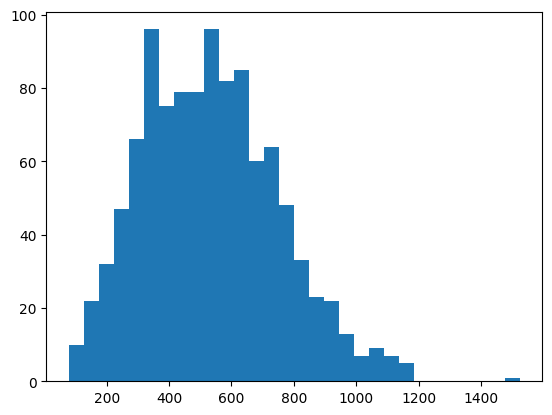

In [63]:
plt.hist(class1["sub_x"],bins=30)

(array([ 26.,  59., 104., 130., 105.,  71.,  98.,  92.,  66.,  63.,  40.,
         34.,  19.,  18.,  13.,  18.,  10.,  10.,  12.,   7.,   6.,   4.,
          9.,   7.,  17.,   8.,   5.,   3.,   5.,   2.]),
 array([  61.        ,  142.96666667,  224.93333333,  306.9       ,
         388.86666667,  470.83333333,  552.8       ,  634.76666667,
         716.73333333,  798.7       ,  880.66666667,  962.63333333,
        1044.6       , 1126.56666667, 1208.53333333, 1290.5       ,
        1372.46666667, 1454.43333333, 1536.4       , 1618.36666667,
        1700.33333333, 1782.3       , 1864.26666667, 1946.23333333,
        2028.2       , 2110.16666667, 2192.13333333, 2274.1       ,
        2356.06666667, 2438.03333333, 2520.        ]),
 <BarContainer object of 30 artists>)

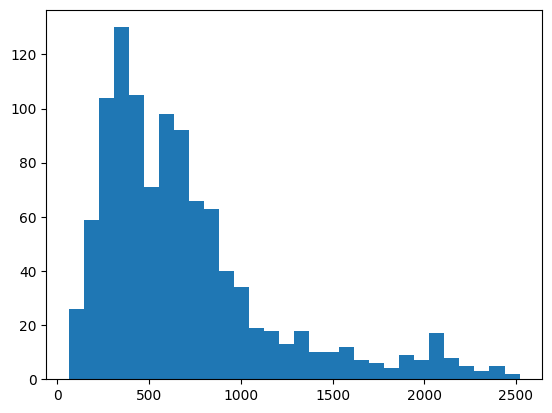

In [64]:
plt.hist(class1["sub_y"],bins=30)

In [9]:
class1.class_id.value_counts()

# [0,3,11,13]
# [8,7,10,9,6,5,2]
# [4,1,12]

class_id
11    4842
13    4655
Name: count, dtype: int64

In [10]:
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [18]:
a = class1.iloc[1]

In [19]:
image = pydicom.dcmread(a.image_path).pixel_array

In [20]:
image = np.amax(image) - image
image = image - np.min(image)
image = image / np.max(image)
image = (image * 255).astype(np.uint8)

image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

In [14]:
y_scale = 512/image.shape[0]
x_scale = 512/image.shape[1]

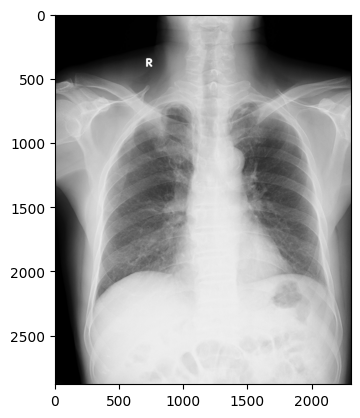

In [21]:
plt.imshow(image)

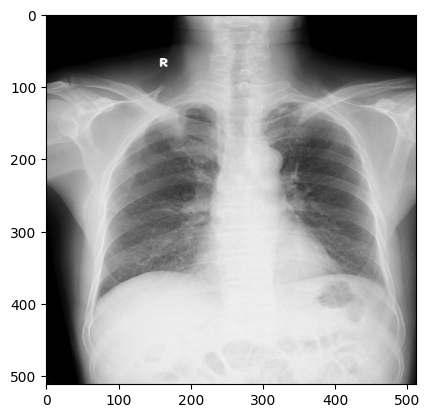

In [69]:
rs_image = cv2.resize(image,(512,512))
plt.imshow(rs_image)

In [22]:
a

image_id                       0007d316f756b3fa0baea2ff514ce945
class_name                                   Pleural thickening
class_id                                                     11
rad_id                                                       R8
x_min                                                     621.0
y_min                                                     673.0
x_max                                                    1025.0
y_max                                                     851.0
label                                                         1
image_path    /home/ubuntu/duynd/AIyte/secondnd/input/train/...
Name: 1, dtype: object

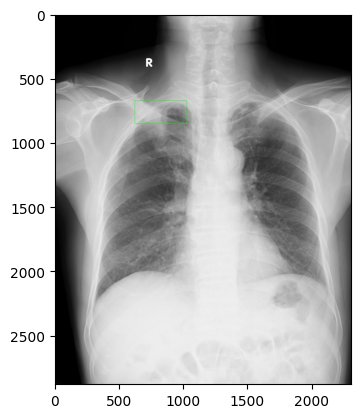

In [23]:
# cv2.rectangle(image, (818,677), (987,939),color=(255,0,0), thickness=2)
image = cv2.rectangle(image, (621,673), (1025,851),color=(0,255,0), thickness=2)
# image = cv2.rectangle(image, (790,634), (1047,725),color=(0,0,255), thickness=2)
# image = cv2.rectangle(image, (818,677), (987,939),color=(0,0,255), thickness=2)
# image = cv2.rectangle(image, (804,716), (857,920),color=(0,255,255), thickness=2) 

plt.imshow(image)

In [24]:
int(round(818*x_scale,0))

182

In [26]:
cv2.rectangle(rs_image, (int(np.round(818*x_scale,0)),int(np.round(677*y_scale,0))), (int(np.round(987*x_scale,0)),int(np.round(939*y_scale,0))),color=(255,0,0), thickness=2)

plt.imshow(rs_image)

NameError: name 'rs_image' is not defined

In [27]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [48]:
bb_intersection_over_union([818.0,677.0,987.0,939.0], [804.0,716.0,857.0,920.0])

0.1723413198823035

In [1]:
import yaml

In [2]:
with open("/home/ubuntu/ductq/pipeline/configs/config1.yaml", 'r',encoding='utf-8') as f:
    configs = yaml.safe_load(f)

In [3]:
configs

{'data': {'voi_lut': True, 'fix_monochrome': True, 'shape': 512},
 'classification': {'model': {'name': 'tf_efficientnet_b0',
   'classes': 1,
   'path': '/home/ubuntu/ductq/results/ckpt/v5/last.ckpt'},
  'predict': {'threshold': 0.7}},
 'detection': {'model': {'name': 'yolov11s',
   'class': 2,
   'path': '/home/ubuntu/ductq/runs/detect/train/weights/last.pt'},
  'predict': {'conf': 0.25, 'iou': 0.6}}}